The original codes are available on https://github.com/shibuiwilliam/audio_classification_keras

# ESC-50 audio classification

This notebook is an example of audio classification using convolutional neural network.
<br>
The data used is [ESC-50](https://github.com/karoldvl/ESC-50), which consists of 50 classes of environmental audio dataset.<br>
One data is in .wav format with 5 seconds each, total of 2,000 files.

In [175]:
import sys
print(sys.version)
print(sys.path)

3.9.7 (default, Sep  3 2021, 12:37:55) 
[Clang 12.0.5 (clang-1205.0.22.9)]
['/usr/local/Cellar/python@3.9/3.9.7/Frameworks/Python.framework/Versions/3.9/lib/python39.zip', '/usr/local/Cellar/python@3.9/3.9.7/Frameworks/Python.framework/Versions/3.9/lib/python3.9', '/usr/local/Cellar/python@3.9/3.9.7/Frameworks/Python.framework/Versions/3.9/lib/python3.9/lib-dynload', '', '/Users/shihoakaki/Library/Python/3.9/lib/python/site-packages', '/usr/local/lib/python3.9/site-packages']


In [62]:
import os
# import random
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
# import seaborn as sn
from sklearn import model_selection
# from sklearn import preprocessing
import IPython.display as ipd
from tqdm import tqdm
from tensorflow.keras.utils import to_categorical

In [4]:
!pip install -r requirements.txt --quiet

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
You should consider upgrading via the '/usr/local/opt/python@3.9/bin/python3.9 -m pip install --upgrade pip' command.


In [63]:
from tensorflow.keras.layers import Add

In [64]:
import keras
from keras.models import Model
from keras.layers import Input, Dense, Dropout, Activation
from keras.layers import Conv2D, GlobalAveragePooling2D
from keras.layers import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model

## Preparation

In [65]:
# load a wave data
def load_wave_data(audio_dir, file_name):
    file_path = os.path.join(audio_dir, file_name)
    x, fs = librosa.load(file_path, sr=44100)
    return x,fs

In [66]:
# change wave data to mel-stft
def calculate_melsp(x, n_fft=1024, hop_length=128):
    stft = np.abs(librosa.stft(x, n_fft=n_fft, hop_length=hop_length))**2
    log_stft = librosa.power_to_db(stft)
    melsp = librosa.feature.melspectrogram(S=log_stft,n_mels=128)
    return melsp

In [67]:
# display wave in plots
def show_wave(x):
    plt.plot(x)
    plt.show()

In [68]:
# display wave in heatmap
def show_melsp(melsp, fs):
    librosa.display.specshow(melsp, sr=fs)
    plt.colorbar()
    plt.show()

In [69]:
# This values are necessary to create and reshape data arrays
freq = 128
time = 1723

### Data is available on https://www.kaggle.com/mmoreaux/environmental-sound-classification-50


In [ ]:
!wget "https://github.com/karoldvl/ESC-50/archive/master.zip"
!unzip -qq master.zip
!cd ESC-50-master

--2024-07-03 12:35:06--  https://github.com/karoldvl/ESC-50/archive/master.zip
github.com (github.com) をDNSに問いあわせています... 20.27.177.113
github.com (github.com)|20.27.177.113|:443 に接続しています... 接続しました。
HTTP による接続要求を送信しました、応答を待っています... 301 Moved Permanently
場所: https://github.com/karolpiczak/ESC-50/archive/master.zip [続く]
--2024-07-03 12:35:07--  https://github.com/karolpiczak/ESC-50/archive/master.zip
github.com:443 への接続を再利用します。
HTTP による接続要求を送信しました、応答を待っています... 302 Found
場所: https://codeload.github.com/karolpiczak/ESC-50/zip/refs/heads/master [続く]
--2024-07-03 12:35:07--  https://codeload.github.com/karolpiczak/ESC-50/zip/refs/heads/master
codeload.github.com (codeload.github.com) をDNSに問いあわせています... 20.27.177.114
codeload.github.com (codeload.github.com)|20.27.177.114|:443 に接続しています... 接続しました。
HTTP による接続要求を送信しました、応答を待っています... 200 OK
長さ: 特定できません [application/zip]
`master.zip' に保存中

master.zip              [                <=> ] 615.78M  3.90MB/s 時間 3m 11s     

2024-07-03 12:38:18 (3.23 MB/s)

In [70]:
# define directories
#base_dir = "../input/environmental-sound-classification-50"
base_dir = ""
esc_dir = os.path.join(base_dir, "ESC-50-master")
meta_file = os.path.join(esc_dir, "meta/esc50.csv")
audio_dir = os.path.join(esc_dir, "audio/")

In [71]:
# load metadata
meta_data = pd.read_csv(meta_file)
meta_data

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A
...,...,...,...,...,...,...,...
1995,5-263831-B-6.wav,5,6,hen,False,263831,B
1996,5-263902-A-36.wav,5,36,vacuum_cleaner,False,263902,A
1997,5-51149-A-25.wav,5,25,footsteps,False,51149,A
1998,5-61635-A-8.wav,5,8,sheep,False,61635,A


In [72]:
# get data size
data_size = meta_data.shape
print(data_size)

(2000, 7)


In [73]:
# arrange target label and its name
class_dict = {}
for i in range(data_size[0]):
    if meta_data.loc[i,"target"] not in class_dict.keys():
        class_dict[meta_data.loc[i,"target"]] = meta_data.loc[i,"category"]
class_pd = pd.DataFrame(list(class_dict.items()), columns=["labels","classes"])
class_pd

,labels,classes
0,0,dog
1,14,chirping_birds
2,36,vacuum_cleaner
3,19,thunderstorm
4,30,door_wood_knock
5,34,can_opening
6,9,crow
7,22,clapping
8,48,fireworks
9,41,chainsaw


## Hint:
It strongly recommended to use kaggle notebook to access data quickly and not mess with library issues.
The trained model with %20 validation data and %10 test data are available on 
https://www.kaggle.com/tubistaj/model-files and
https://www.kaggle.com/tubistaj/test-array.

If you prefer use them you can continue with section ***Evaluate model***.
Otherwise, of course you are free to go ahead

## Load dataset

wave size:(220500,)
melsp size:(128, 1723)
samping rate:44100


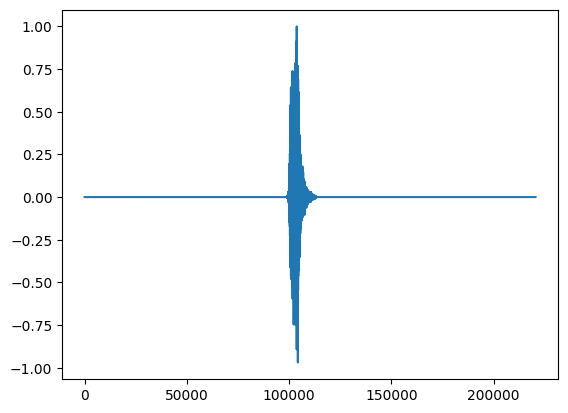

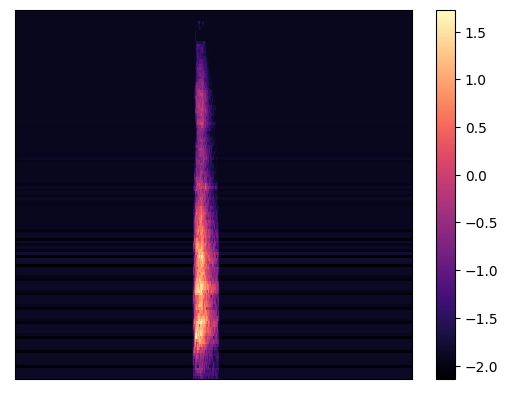

In [75]:
# example data
x, fs = load_wave_data(audio_dir, meta_data.loc[0,"filename"])
melsp = calculate_melsp(x)
print("wave size:{0}\nmelsp size:{1}\nsamping rate:{2}".format(x.shape, melsp.shape, fs))
show_wave(x)
show_melsp(melsp, fs)

In [76]:
ipd.Audio(x, rate=fs)

## Augment audio data

The augmented data available on https://www.kaggle.com/tubistaj/esc50aug, with using it you can pass this sections up to *Audio Classification with Deep Learning* section

The number of end of file names indicates the rate of splitting data in train and test. ie. esc_melsp_train_raw3.npz means %30 test rate.

However, if you do not want to use link you can go ahead.

In [77]:
# data augmentation: add white noise
def add_white_noise(x, rate=0.002):
    return x + rate*np.random.randn(len(x))

wave size:(220500,)
melsp size:(128, 1723)
samping rate:44100


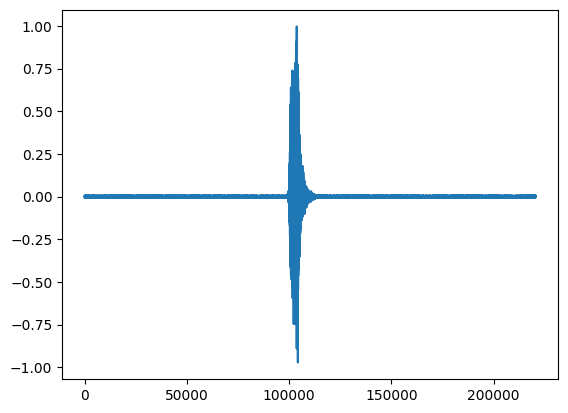

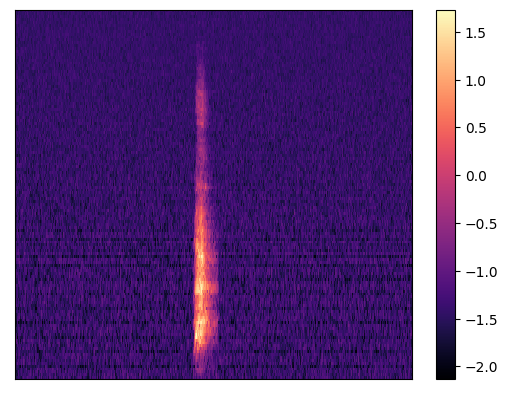

In [78]:
x_wn = add_white_noise(x)
melsp = calculate_melsp(x_wn)
print("wave size:{0}\nmelsp size:{1}\nsamping rate:{2}".format(x_wn.shape, melsp.shape, fs))
show_wave(x_wn)
show_melsp(melsp, fs)

In [79]:
ipd.Audio(x_wn, rate=fs)

In [80]:
# data augmentation: shift sound in timeframe
def shift_sound(x, rate=2):
    return np.roll(x, int(len(x)//rate))

wave size:(220500,)
melsp size:(128, 1723)
samping rate:44100


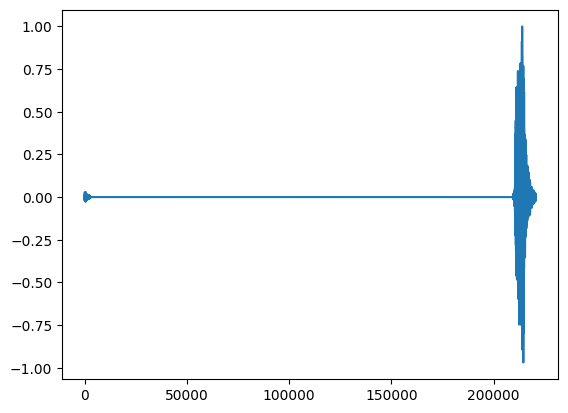

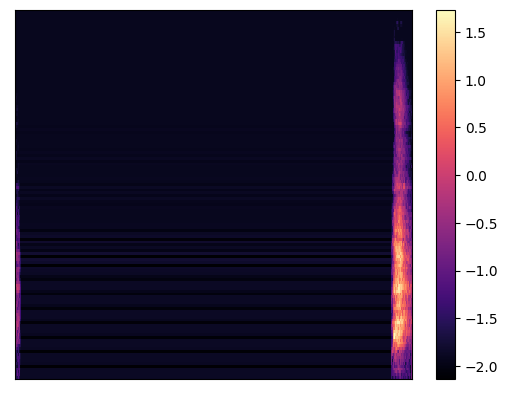

In [81]:
x_ss = shift_sound(x)
melsp = calculate_melsp(x_ss)
print("wave size:{0}\nmelsp size:{1}\nsamping rate:{2}".format(x_ss.shape, melsp.shape, fs))
show_wave(x_ss)
show_melsp(melsp, fs)

In [82]:
ipd.Audio(x_ss, rate=fs)

In [83]:
# data augmentation: stretch sound
def stretch_sound(x, rate=1.1):
    input_length = len(x)
    x = librosa.effects.time_stretch(x, rate)
    if len(x)>input_length:
        return x[:input_length]
    else:
        return np.pad(x, (0, max(0, input_length - len(x))), "constant")

wave size:(220500,)
melsp size:(128, 1723)
samping rate:44100


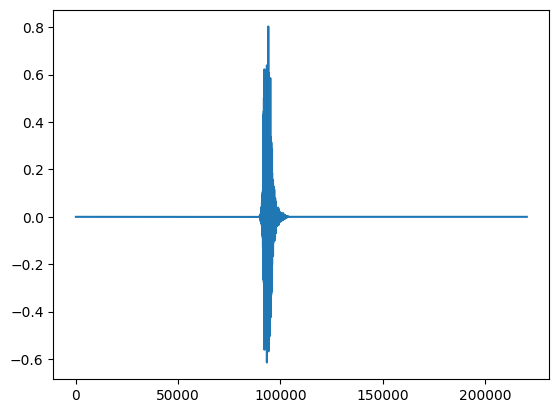

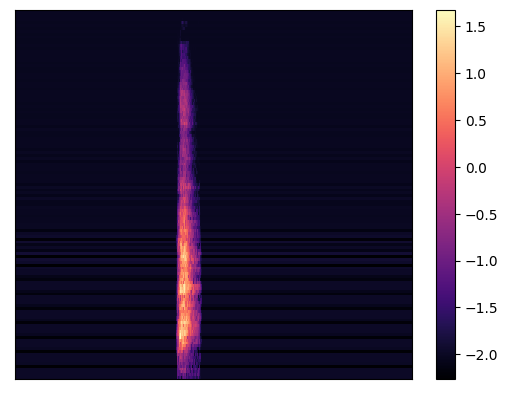

In [84]:
x_st = stretch_sound(x)
melsp = calculate_melsp(x_st)
print("wave size:{0}\nmelsp size:{1}\nsamping rate:{2}".format(x_st.shape, melsp.shape, fs))
show_wave(x_st)
show_melsp(melsp, fs)

In [85]:
ipd.Audio(x_st, rate=fs)

## Split training dataset and test dataset

In [86]:
# get training dataset and target dataset
x = list(meta_data.loc[:, "filename"])
y = list(meta_data.loc[:, "target"])

x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, test_size=0.25, stratify=y)
print("x train:{0}\ny train:{1}\nx test:{2}\ny test:{3}".format(len(x_train),
                                                                len(y_train), 
                                                                len(x_test), 
                                                                len(y_test)))

x train:1500
y train:1500
x test:500
y test:500


In [88]:
x_train

['2-102414-D-17.wav',
 '5-213077-A-11.wav',
 '4-130891-A-7.wav',
 '4-172732-A-36.wav',
 '5-213293-A-23.wav',
 '1-155858-B-25.wav',
 '4-188703-D-8.wav',
 '4-192236-A-0.wav',
 '2-59565-A-46.wav',
 '4-187284-A-30.wav',
 '1-33658-A-26.wav',
 '5-211197-A-24.wav',
 '3-164216-A-6.wav',
 '4-181707-A-32.wav',
 '5-195557-A-19.wav',
 '1-53444-A-28.wav',
 '5-263775-A-26.wav',
 '4-132816-A-26.wav',
 '3-166324-A-15.wav',
 '2-122104-A-0.wav',
 '2-132157-B-11.wav',
 '2-95567-A-23.wav',
 '2-92627-A-27.wav',
 '2-151079-A-20.wav',
 '3-156581-A-14.wav',
 '4-195497-A-11.wav',
 '5-242932-B-26.wav',
 '5-172299-A-5.wav',
 '5-260875-A-35.wav',
 '2-81190-A-34.wav',
 '5-209992-A-44.wav',
 '1-13572-A-46.wav',
 '1-56233-A-9.wav',
 '2-173618-A-39.wav',
 '1-96950-A-9.wav',
 '5-251426-B-30.wav',
 '3-164216-C-6.wav',
 '4-184237-A-28.wav',
 '3-253084-B-2.wav',
 '4-156827-A-46.wav',
 '5-212736-A-17.wav',
 '3-65748-A-12.wav',
 '3-70962-B-4.wav',
 '2-108760-A-14.wav',
 '4-183882-B-28.wav',
 '2-141563-A-39.wav',
 '5-253085

In [89]:
a = np.zeros(50)
for c in y_test:
    a[c] += 1
print(a)

[10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.]


## Transform wav data to mel-stft array 

Transform wav data files to mel-stft array, and save them as npz, separately with test, training and augmented training datasets.


In [ ]:
# save wave data in npz, with augmentation
def save_np_data(filename, x, y, aug=None, rates=None):
    np_data = np.zeros(freq*time*len(x)).reshape(len(x), freq, time)
    np_targets = np.zeros(len(y))
    for i in range(len(y)):
        _x, fs = load_wave_data(audio_dir, x[i])
        if aug is not None:
            _x = aug(x=_x, rate=rates[i])
        _x = calculate_melsp(_x)
        np_data[i] = _x
        np_targets[i] = y[i]
    np.savez(filename, x=np_data, y=np_targets)  

In [ ]:
# save test dataset
if not os.path.exists("esc_melsp_test.npz"):
    save_np_data("esc_melsp_test.npz", x_test,  y_test)

In [ ]:
# save raw training dataset
if not os.path.exists("esc_melsp_train_raw.npz"):
    save_np_data("esc_melsp_train_raw.npz", x_train,  y_train)

In [ ]:
# save training dataset with white noise
if not os.path.exists("esc_melsp_train_wn.npz"):
    rates = np.random.randint(1,50,len(x_train))/10000
    save_np_data("esc_melsp_train_wn.npz", x_train,  y_train, aug=add_white_noise, rates=rates)

In [ ]:
# save training dataset with sound shift
if not os.path.exists("esc_melsp_train_ss.npz"):
    rates = np.random.choice(np.arange(2,6),len(y_train))
    save_np_data("esc_melsp_train_ss.npz", x_train,  y_train, aug=shift_sound, rates=rates)

In [ ]:
# save training dataset with stretch
if not os.path.exists("esc_melsp_train_st.npz"):
    rates = np.random.choice(np.arange(80,120),len(y_train))/100
    save_np_data("esc_melsp_train_st.npz", x_train,  y_train, aug=stretch_sound, rates=rates)

In [ ]:
# save training dataset with combination of white noise and shift or stretch
if not os.path.exists("esc_melsp_train_com.npz"):
    np_data = np.zeros(freq*time*len(x_train)).reshape(len(x_train), freq, time)
    np_targets = np.zeros(len(y_train))
    for i in range(len(y_train)):
        x, fs = load_wave_data(audio_dir, x_train[i])
        x = add_white_noise(x=x, rate=np.random.randint(1,50)/1000)
        if np.random.choice((True,False)):
            x = shift_sound(x=x, rate=np.random.choice(np.arange(2,6)))
        else:
            x = stretch_sound(x=x, rate=np.random.choice(np.arange(80,120))/100)
        x = calculate_melsp(x)
        np_data[i] = x
        np_targets[i] = y_train[i]
    np.savez("esc_melsp_train_com.npz", x=np_data, y=np_targets)

# Audio classification with deep learning


## Preparation for deep learning

In [90]:
# dataset files are available on https://www.kaggle.com/tubistaj/esc50aug 
files_dir = ''
train_files = [files_dir + "esc_melsp_train_raw.npz", 
               files_dir + "esc_melsp_train_ss.npz",
               files_dir + "esc_melsp_train_st.npz", 
               files_dir + "esc_melsp_train_wn.npz",
               files_dir + "esc_melsp_train_com.npz"]
test_file = files_dir + "esc_melsp_test.npz"

In [91]:
train_num = 1500 #1400?
test_num = 500  #600?

In [92]:
# load dataset
for i in tqdm(range(len(train_files))):
    data = np.load(train_files[i])
    x_train[i*train_num:(i+1)*train_num] = data["x"]
    y_train[i*train_num:(i+1)*train_num] = data["y"]

100%|██████████| 5/5 [01:38<00:00, 19.69s/it]


In [99]:
x_train = np.array(x_train)
x_test = np.array(x_test)

In [133]:
# load test dataset
test_data = np.load(test_file)
x_test = test_data["x"]
y_test = test_data["y"]

In [101]:
#!pip show keras
from tensorflow.keras import utils as np_utils


In [102]:
# redefine target data into one hot vector
classes = 50
y_train = np_utils.to_categorical(y_train, classes)
y_test = np_utils.to_categorical(y_test, classes)

In [103]:
# reshape training dataset
x_train = x_train.reshape(train_num*len(train_files), freq, time, 1) # 実行可能 1500
x_test = x_test.reshape(test_num, freq, time, 1) #600

In [104]:
# test data splitted to validation while learning and test in end of learning as %20 and %10
x_test, x_val, y_test, y_val= model_selection.train_test_split(x_test, y_test, test_size=2/3, random_state=1)

In [105]:

print("x train:{0}\ny train:{1}\nx val:{2}\ny val:{3}\nx test:{4}\ny test:{5}".format(x_train.shape,
                                                                                      y_train.shape,
                                                                                      x_val.shape,
                                                                                      y_val.shape,
                                                                                      x_test.shape, 
                                                                                      y_test.shape))

x train:(7500, 128, 1723, 1)
y train:(7500, 50)
x val:(334, 128, 1723, 1)
y val:(334, 50)
x test:(166, 128, 1723, 1)
y test:(166, 50)


## Define convolutional neural network

In [ ]:
# これをDLして動かしたらうまくいったがその後コメントアウトしてもうまくいった
#from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Input, Add, GlobalAveragePooling2D, Dense
#from tensorflow.keras.models import Model

In [106]:
def cba(x, filters, kernel_size, strides):
    #x = Conv2D(filters, kernel_size=kernel_size, strides=strides, padding='same')(inputs)
    x = Conv2D(filters, kernel_size, strides=strides, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

In [107]:
inputs = Input(shape=(x_train.shape[1:]))
type(inputs)

keras.engine.keras_tensor.KerasTensor

In [108]:
# define CNN
# CNNの定義


inputs = Input(shape=(x_train.shape[1:]))

x_1 = cba(inputs, filters=32, kernel_size=(1,8), strides=(1,2))
x_1 = cba(x_1, filters=32, kernel_size=(8,1), strides=(2,1))
x_1 = cba(x_1, filters=64, kernel_size=(1,8), strides=(1,2))
x_1 = cba(x_1, filters=64, kernel_size=(8,1), strides=(2,1))

x_2 = cba(inputs, filters=32, kernel_size=(1,16), strides=(1,2))
x_2 = cba(x_2, filters=32, kernel_size=(16,1), strides=(2,1))
x_2 = cba(x_2, filters=64, kernel_size=(1,16), strides=(1,2))
x_2 = cba(x_2, filters=64, kernel_size=(16,1), strides=(2,1))

x_3 = cba(inputs, filters=32, kernel_size=(1,32), strides=(1,2))
x_3 = cba(x_3, filters=32, kernel_size=(32,1), strides=(2,1))
x_3 = cba(x_3, filters=64, kernel_size=(1,32), strides=(1,2))
x_3 = cba(x_3, filters=64, kernel_size=(32,1), strides=(2,1))

x_4 = cba(inputs, filters=32, kernel_size=(1,64), strides=(1,2))
x_4 = cba(x_4, filters=32, kernel_size=(64,1), strides=(2,1))
x_4 = cba(x_4, filters=64, kernel_size=(1,64), strides=(1,2))
x_4 = cba(x_4, filters=64, kernel_size=(64,1), strides=(2,1))

x = Add()([x_1, x_2, x_3, x_4])

x = cba(x, filters=128, kernel_size=(1,16), strides=(1,2))
x = cba(x, filters=128, kernel_size=(16,1), strides=(2,1))

x = GlobalAveragePooling2D()(x)
x = Dense(classes)(x)
x = Activation("softmax")(x)

model = Model(inputs, x)
model.summary()



2024-07-03 15:34:04.326415: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 1723,   0           []                               
                                1)]                                                               
                                                                                                  
 conv2d (Conv2D)                (None, 128, 862, 32  288         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_4 (Conv2D)              (None, 128, 862, 32  544         ['input_2[0][0]']                
                                )                                                             

## Optimization and callbacks

In [109]:
!pip show keras
!pip install keras --upgrade

Python(25337) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Name: keras
Version: 2.7.0
Summary: Deep learning for humans.
Home-page: https://keras.io/
Author: Keras team
Author-email: keras-users@googlegroups.com
License: Apache 2.0
Location: /usr/local/lib/python3.9/site-packages
Requires: 
Required-by: keras-models, tensorflow, tensorflow-cpu


Python(25339) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
  Using cached keras-3.4.1-py3-none-any.whl (1.1 MB)
^C
ERROR: Operation cancelled by user
You should consider upgrading via the '/usr/local/opt/python@3.9/bin/python3.9 -m pip install --upgrade pip' command.


In [110]:
from tensorflow.keras.optimizers import Adam

# Initialize the optimizer with the correct parameter names
opt = Adam(learning_rate=0.00005, decay=1e-6)  # Using 'lr' instead of 'learning_rate'

# Compile the model with the correctly initialized optimizer
model.compile(
    loss='categorical_crossentropy',
    optimizer=opt,
    metrics=['acc']
)


In [111]:
# import
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint

In [112]:
# directory for model checkpoints
model_dir = "./models"
if not os.path.exists(model_dir):
    os.mkdir(model_dir)

# early stopping and model checkpoints
# saves the model in each decreasing val_loss
es_cb = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')
chkpt = os.path.join(model_dir, 'esc50_.{epoch:02d}_{val_loss:.4f}_{val_acc:.4f}.hdf5')
cp_cb = ModelCheckpoint(filepath = chkpt, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

## Train CNN model with between class dataset

In [113]:
# between class data generator
class MixupGenerator():
    def __init__(self, x_train, y_train, batch_size=32, alpha=0.2, shuffle=True):
        self.x_train = x_train
        self.y_train = y_train
        self.batch_size = batch_size
        self.alpha = alpha
        self.shuffle = shuffle
        self.sample_num = len(x_train)

    def __call__(self):
        while True:
            indexes = self.__get_exploration_order()
            itr_num = int(len(indexes) // (self.batch_size * 2))

            for i in range(itr_num):
                batch_ids = indexes[i * self.batch_size * 2:(i + 1) * self.batch_size * 2]
                x, y = self.__data_generation(batch_ids)

                yield x, y

    def __get_exploration_order(self):
        indexes = np.arange(self.sample_num)

        if self.shuffle:
            np.random.shuffle(indexes)

        return indexes

    def __data_generation(self, batch_ids):
        _, h, w, c = self.x_train.shape
        _, class_num = self.y_train.shape
        x1 = self.x_train[batch_ids[:self.batch_size]]
        x2 = self.x_train[batch_ids[self.batch_size:]]
        y1 = self.y_train[batch_ids[:self.batch_size]]
        y2 = self.y_train[batch_ids[self.batch_size:]]
        l = np.random.beta(self.alpha, self.alpha, self.batch_size)
        x_l = l.reshape(self.batch_size, 1, 1, 1)
        y_l = l.reshape(self.batch_size, 1)

        x = x1 * x_l + x2 * (1 - x_l)
        y = y1 * y_l + y2 * (1 - y_l)

        return x, y

In [116]:
# train model
# 32 batch size takes 15 GB of RAM
# 60-32
batch_size = 1024
epochs = 2

training_generator = MixupGenerator(x_train, y_train)()
model.fit_generator(generator=training_generator,
                    steps_per_epoch=x_train.shape[0] // batch_size,
                    validation_data=(x_val, y_val),
                    epochs=epochs, 
                    verbose=1,
                    callbacks=[es_cb, cp_cb],
                    shuffle=True)

/var/folders/vs/x3fvf7cx37n1tbgzfjpym8n80000gn/T/ipykernel_25084/4114105989.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator=training_generator,


Epoch 1/2
7/7 [==============================] - ETA: 0s - loss: 3.8350 - acc: 0.0446 
Epoch 00001: val_loss improved from inf to 3.90851, saving model to ./models/esc50_.01_3.9085_0.0180.hdf5


/usr/local/lib/python3.9/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


7/7 [==============================] - 465s 68s/step - loss: 3.8350 - acc: 0.0446 - val_loss: 3.9085 - val_acc: 0.0180
Epoch 2/2
7/7 [==============================] - ETA: 0s - loss: 3.7263 - acc: 0.0804 
Epoch 00002: val_loss did not improve from 3.90851
7/7 [==============================] - 492s 73s/step - loss: 3.7263 - acc: 0.0804 - val_loss: 3.9095 - val_acc: 0.0150


## Evaluate model

If you use prepared model and test file uncomment the bottom section.

In [134]:
model = load_model("models/esc50_.46_0.7929_0.8050.hdf5")
#test_data = np.load("../input/test-array/test.npz") cannot find
#test_data = np.load("esc_melsp_test.npz")
#test_data = np.load("esc_melsp_train_ss.npz")
x_test = test_data["x"] # feature data
y_test = test_data["y"] # label data

In [150]:
#動かない

#evaluation = model.evaluate(x_test, y_test)
#print(evaluation)

# 16/16 [==============================] - 4s 244ms/step - loss: 0.7291 - acc: 0.8320
# [0.7290524244308472, 0.8320000171661377]

# with test data
# 7/7 [==============================] - 2s 244ms/step - loss: 0.6410 - acc: 0.8500
# [0.6409585475921631, 0.8500000238418579]

In [ ]:
# It used for save splitted test file
# np.savez('test.npz', x=x_test, y=y_test)  

## Testing and sketching confusion matrix

In [139]:
from sklearn.metrics import accuracy_score, confusion_matrix
def conf_matrix(x_test=x_test, y_test=y_test):
    y_pred = []
    y_true = []
    for i in tqdm(range(len(y_test))):
        y_true.append(np.argsort(y_test[i])[::-1][0])
        preds = model.predict(x_test[i].reshape(1, freq, time, 1)) # get a predict for specific sample
        sorted_array = np.argsort(preds).flatten()[::-1] # sort the predict and get a top
        top = sorted_array[0]
        y_pred.append(top)
    print(accuracy_score(y_true, y_pred))
    cm = confusion_matrix(y_true, y_pred)
    return cm

In [140]:
import itertools
import matplotlib.pyplot as plt
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    plt.figure(figsize=(24,24))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

In [144]:
# cmで二次元行列を作る, 
cm = conf_matrix(x_test, y_test)

100%|██████████| 500/500 [02:32<00:00,  3.28it/s]

0.02


/var/folders/vs/x3fvf7cx37n1tbgzfjpym8n80000gn/T/ipykernel_25084/2584453776.py:12: RuntimeWarning: invalid value encountered in true_divide
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


Normalized confusion matrix


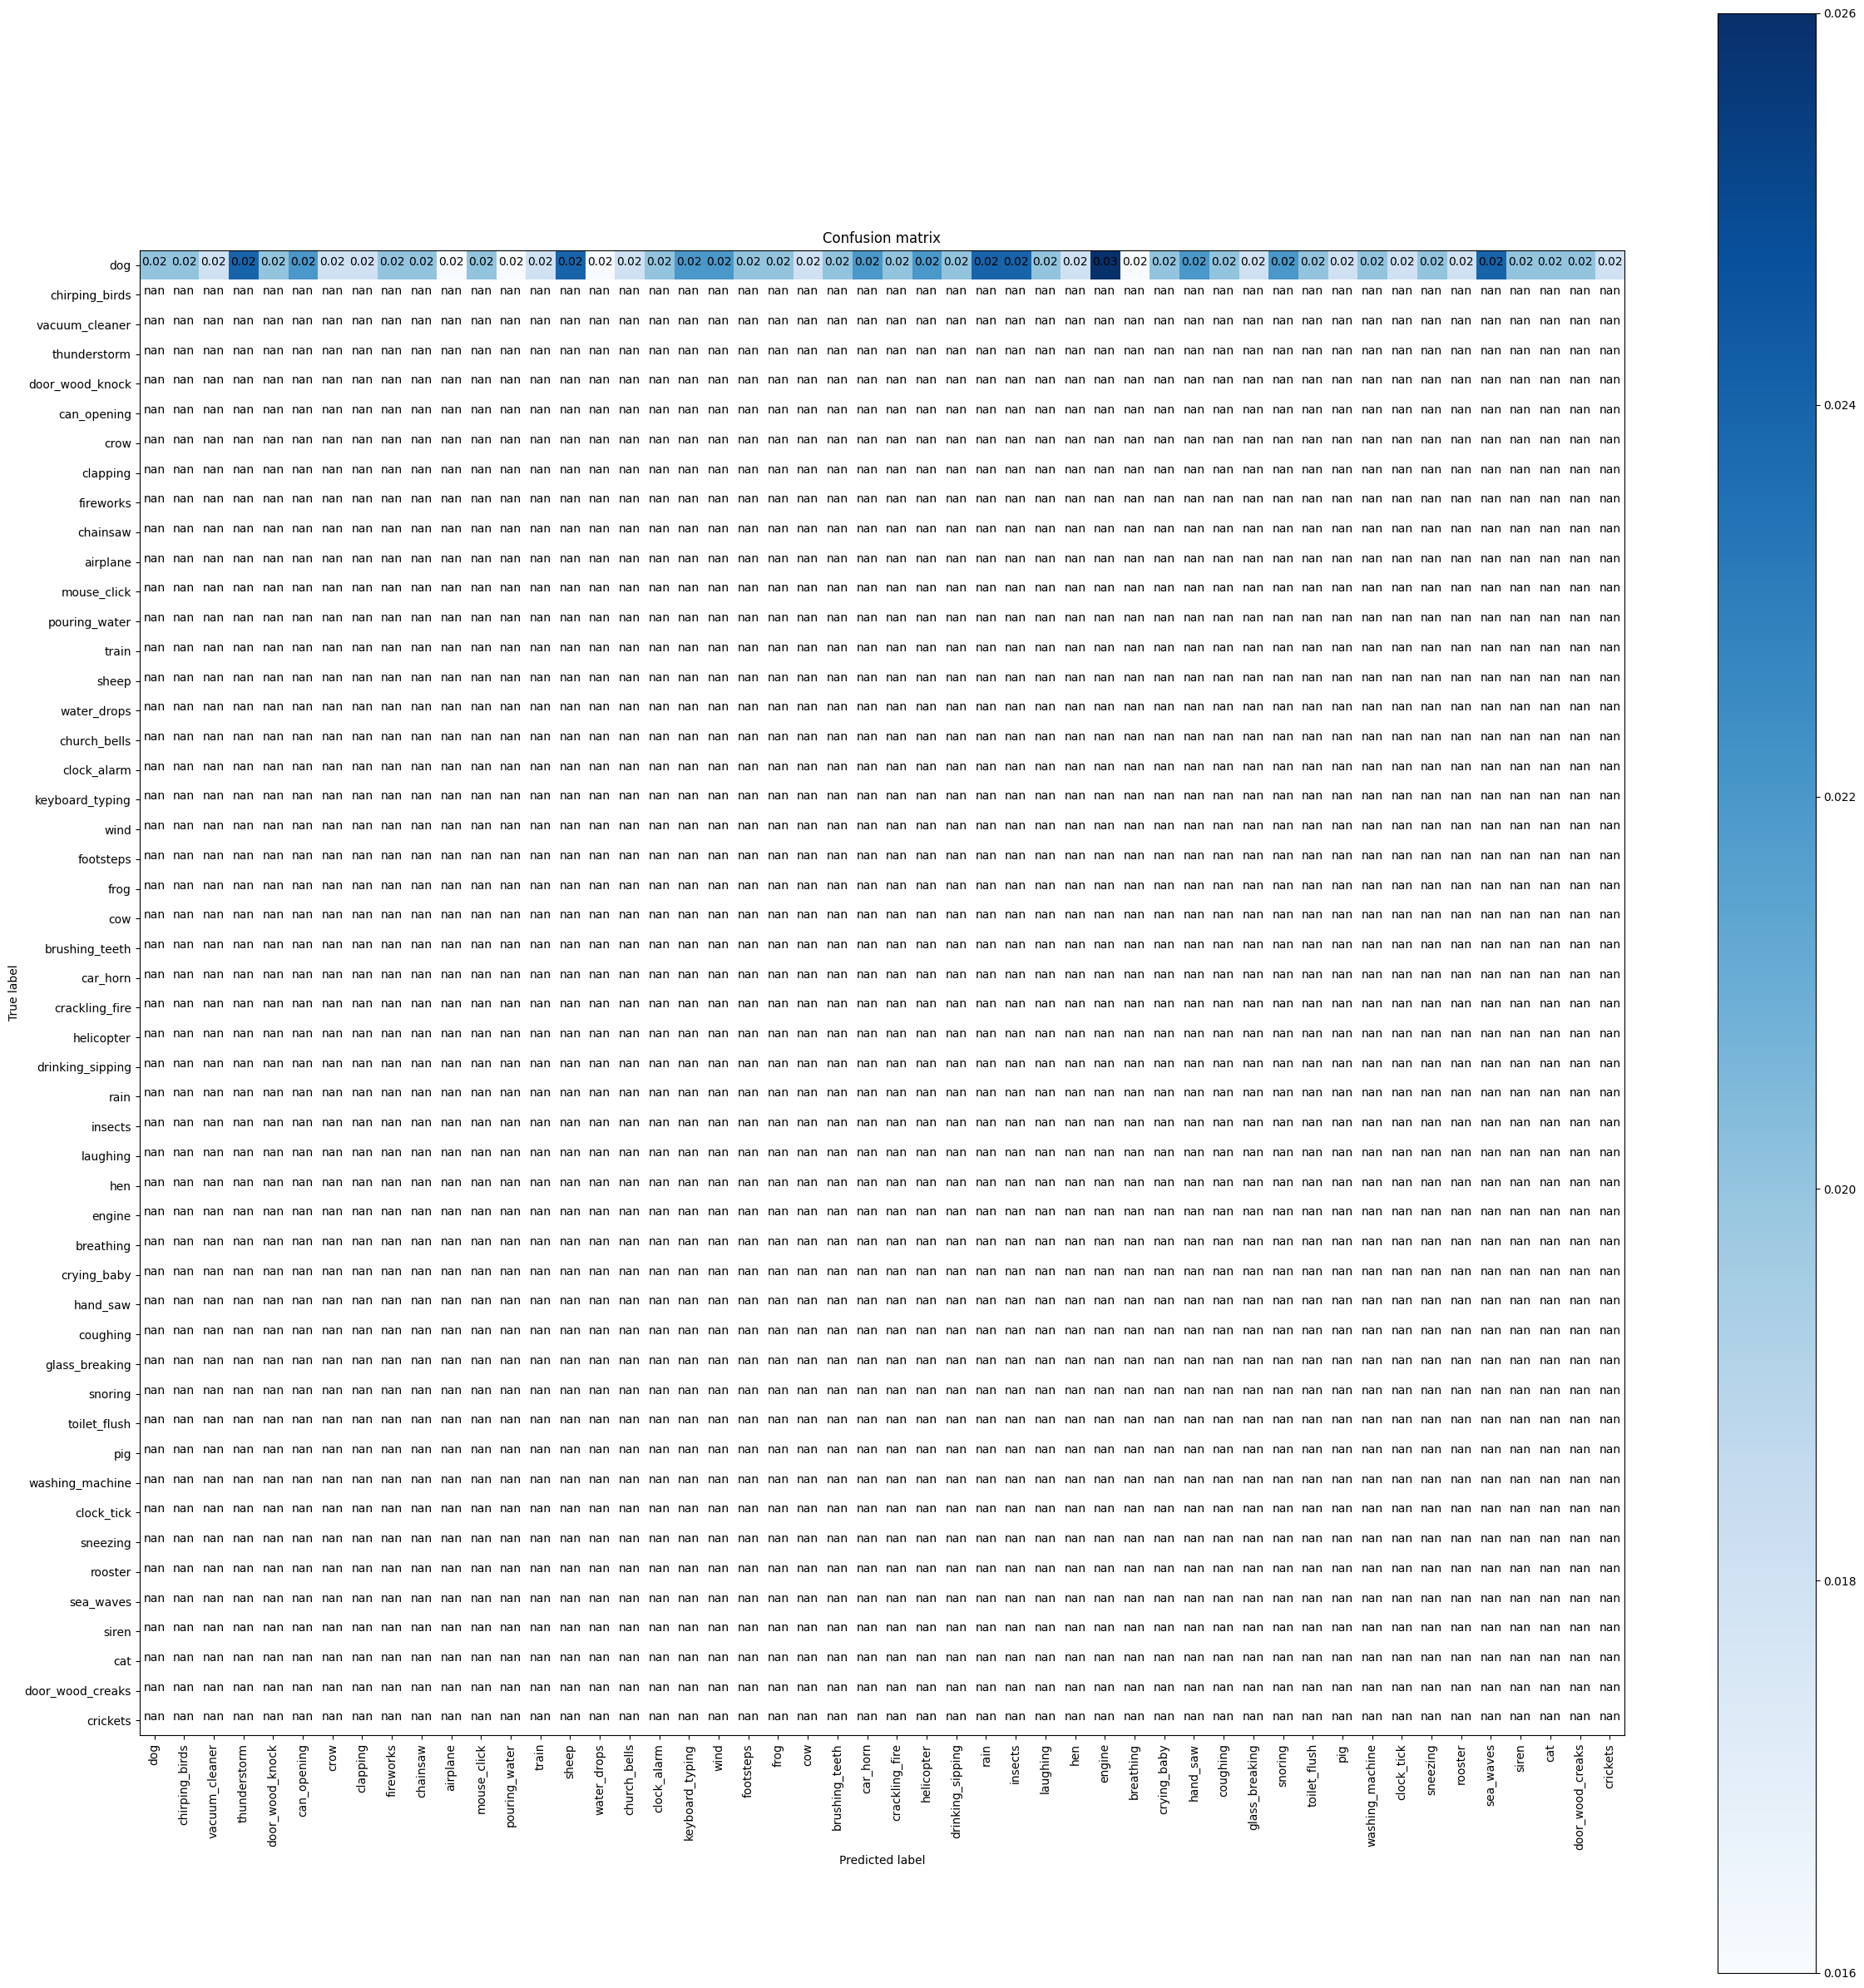

In [ ]:
class_names = np.asarray(class_pd.classes)
plot_confusion_matrix(cm, class_names)

## Predict One

In [ ]:
def predict_one(file_path, k, threshold=0.25):
    expected_shape = (1, freq, time, 1)
    x, fs = librosa.load(file_path, sr=44100)
    show_wave(x)
    show_melsp(calculate_melsp(x), fs)
    if (freq-1)*time < x.size < freq*time: 
        melsp_x = calculate_melsp(x)
    else:
        x_new = np.zeros(freq*time-1)
        x_new.flat[:freq*time-1] = x
        melsp_x = calculate_melsp(x_new)
        print("Signal reshaped", x_new.shape)
        show_wave(x_new)
        show_melsp(melsp_x, fs)

    melsp_x = melsp_x.reshape(expected_shape)
    preds = model.predict(melsp_x).flatten()
    sorted_array = np.argsort(preds)[::-1]
    top_k = sorted_array[:k]
    classes = []
    for i in top_k:
        classes.append(class_pd.classes[class_pd[class_pd.labels == i].index[0]])
    if preds[top_k[0]] < threshold:
        print("Not sure about result...", preds[top_k[0]])
    else:
        print(classes)
    return ipd.Audio(x, rate=fs)


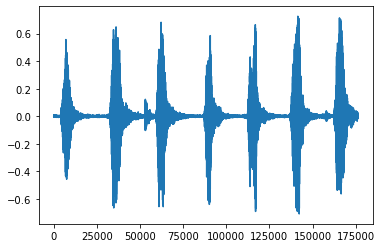

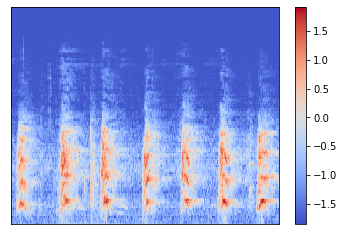

Signal reshaped (220543,)


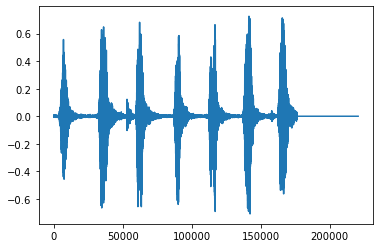

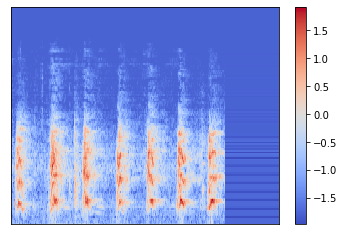

['dog', 'crow', 'rooster']


In [ ]:
file_path = '../input/urbansound8k/fold2/100652-3-0-3.wav'
predict_one(file_path, 3, 0.5)